* In previous Notebook, we had taken `2 characters` only as the context to build a Bigram model or the Neural Network, that result into `27*27 = 729` elements matrix.

* If we have used `3 characters`, It would have been `27*27*27=19,683` `(Trigram)`, so it is increasing exponentially, and so `to predict names` more efficiently, It will `become so tedious and computationally impossible` to make model with this approach.

* So, Today, we will use `Multi-layer Perceptron Model` to `predict next character in the sequence`.

* This `MLP Model` is based on <a href="https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf">Bengio et al. 2003</a> Research Paper.

# Multi-Layer Perceptron Model

In [185]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [186]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-03-26 08:12:41--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.1’

names.txt.1         100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2023-03-26 08:12:41 (10.5 MB/s) - ‘names.txt.1’ saved [228145/228145]



In [187]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [188]:
len(words)

32033

In [189]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


* Building our DataSet.

#### Understanding our data set and neural network with 5 words

In [190]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?


X, Y = [], []
for w in words[:5]:

  print(w)
  context = [0] * block_size # [0, 0, 0] for block_size = 3
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [191]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [192]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [193]:
Y


tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [194]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

##### `Embedding`

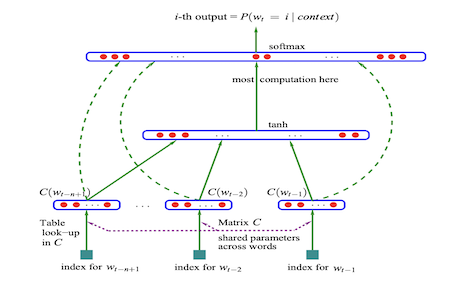

In [195]:
C = torch.randn((27,2)) # embedding lookup table C

In [196]:
C

tensor([[ 0.1722,  0.6197],
        [ 0.7203, -0.9509],
        [-0.5019,  2.3684],
        [-0.2406,  1.0590],
        [-0.1292,  0.5157],
        [-0.8353, -2.1217],
        [-0.3438, -0.5029],
        [ 0.6235, -2.0501],
        [-0.1429, -1.3824],
        [-0.4214,  0.3601],
        [-0.4574,  1.1951],
        [ 0.4673,  0.3050],
        [ 0.1628, -0.3579],
        [ 1.6825, -0.4062],
        [-0.6402, -0.9946],
        [-0.4957, -1.6070],
        [-0.6812, -1.2705],
        [ 0.9628,  2.8217],
        [-0.1288, -0.3062],
        [-1.2979,  3.6105],
        [ 1.0044, -1.7084],
        [ 0.6651,  0.3093],
        [-0.0487, -0.6607],
        [ 1.3830, -0.1094],
        [-1.8317, -1.5540],
        [-0.8911,  1.8920],
        [-0.6342, -2.0784]])

* let's embed our 27 characters in a 2 dimensional space.


* we have 27 possible characters we're going to embed them in a lower dimensional space.
* say `we have 17000 words and so we're going to embed them in spaces as small dimensional as 30`.

In [197]:
C[5]

tensor([-0.8353, -2.1217])

In [198]:
C[torch.tensor([1, 2, 3])].shape

torch.Size([3, 2])

In [199]:
C[torch.tensor([1, 2, 3])]

tensor([[ 0.7203, -0.9509],
        [-0.5019,  2.3684],
        [-0.2406,  1.0590]])

In [200]:
torch.tensor([1, 2, 3]).shape

torch.Size([3])

In [201]:
C

tensor([[ 0.1722,  0.6197],
        [ 0.7203, -0.9509],
        [-0.5019,  2.3684],
        [-0.2406,  1.0590],
        [-0.1292,  0.5157],
        [-0.8353, -2.1217],
        [-0.3438, -0.5029],
        [ 0.6235, -2.0501],
        [-0.1429, -1.3824],
        [-0.4214,  0.3601],
        [-0.4574,  1.1951],
        [ 0.4673,  0.3050],
        [ 0.1628, -0.3579],
        [ 1.6825, -0.4062],
        [-0.6402, -0.9946],
        [-0.4957, -1.6070],
        [-0.6812, -1.2705],
        [ 0.9628,  2.8217],
        [-0.1288, -0.3062],
        [-1.2979,  3.6105],
        [ 1.0044, -1.7084],
        [ 0.6651,  0.3093],
        [-0.0487, -0.6607],
        [ 1.3830, -0.1094],
        [-1.8317, -1.5540],
        [-0.8911,  1.8920],
        [-0.6342, -2.0784]])

In [202]:
torch.tensor([[0, 1], [2, 3]]).shape

torch.Size([2, 2])

In [203]:
C[torch.tensor([[0, 1], [2, 3]])]

tensor([[[ 0.1722,  0.6197],
         [ 0.7203, -0.9509]],

        [[-0.5019,  2.3684],
         [-0.2406,  1.0590]]])

In [204]:
C[torch.tensor([[0, 1], [2, 3]])].shape

torch.Size([2, 2, 2])

In [205]:
C[X]

tensor([[[ 0.1722,  0.6197],
         [ 0.1722,  0.6197],
         [ 0.1722,  0.6197]],

        [[ 0.1722,  0.6197],
         [ 0.1722,  0.6197],
         [-0.8353, -2.1217]],

        [[ 0.1722,  0.6197],
         [-0.8353, -2.1217],
         [ 1.6825, -0.4062]],

        [[-0.8353, -2.1217],
         [ 1.6825, -0.4062],
         [ 1.6825, -0.4062]],

        [[ 1.6825, -0.4062],
         [ 1.6825, -0.4062],
         [ 0.7203, -0.9509]],

        [[ 0.1722,  0.6197],
         [ 0.1722,  0.6197],
         [ 0.1722,  0.6197]],

        [[ 0.1722,  0.6197],
         [ 0.1722,  0.6197],
         [-0.4957, -1.6070]],

        [[ 0.1722,  0.6197],
         [-0.4957, -1.6070],
         [ 0.1628, -0.3579]],

        [[-0.4957, -1.6070],
         [ 0.1628, -0.3579],
         [-0.4214,  0.3601]],

        [[ 0.1628, -0.3579],
         [-0.4214,  0.3601],
         [-0.0487, -0.6607]],

        [[-0.4214,  0.3601],
         [-0.0487, -0.6607],
         [-0.4214,  0.3601]],

        [[-0.0487, -0

In [206]:
D = torch.randn((28, 2))

In [207]:
C[X].shape == D[X].shape

True

* we've done something similar in part 1, that is one-hot encoding

In [208]:
F.one_hot(torch.tensor(5), num_classes=27).dtype

torch.int64

In [209]:
F.one_hot(torch.tensor(5), num_classes=27)

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

In [210]:
F.one_hot(torch.tensor(5), num_classes=27).shape

torch.Size([27])

In [211]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C # Only float and float can do multiplication not int and float

tensor([-0.8353, -2.1217])

* we get the same result as `C[5]`, this means,

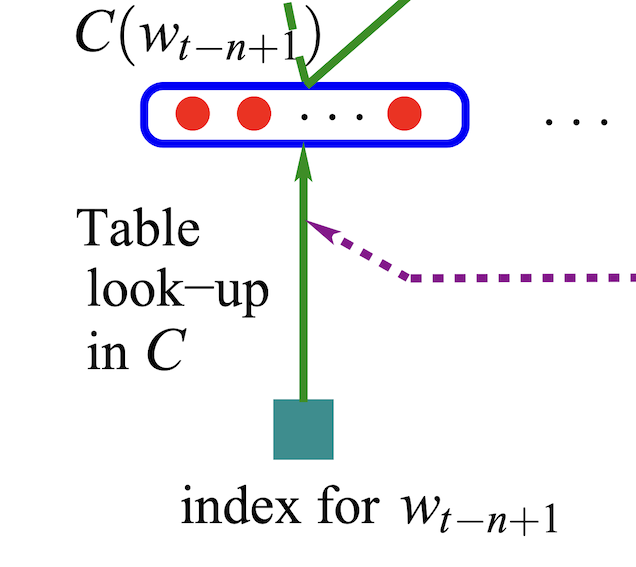

* This embedding of integer, we can think it as the `integer indexing` into a `lookup table C` But equivalently we can also think of this `little blue square` as a first layer of this bigger neural net, This `Blue rectangle box with red dots` is like a `layer`, that has no non-linearity, there is no `tanh`, it's just linear `neurons`, and `their weight matrix is C`. 

* And then we are encoding integers into `one-hot` and feeding those into a `neural net` and `this first layer basically embeds them`.

* So this is `two equivalent ways of doing same thing.` we will use `indexing`, because it is much more faster than `one-hot encoding`.

#### embedding whole `X` in `C`.

In [212]:
C[X].shape

torch.Size([32, 3, 2])

* 32 by 3, which is `original shape`, and now for every one of those 32 by 3 integers, we've `retrieved the embedding vector 2`.

In [213]:
X[13, 2]

tensor(1)

In [214]:
X[13]

tensor([0, 0, 1])

In [215]:
C[X][13, 2] # embedding for X[13, 2]

tensor([ 0.7203, -0.9509])

In [216]:
C[1] # which is also same , why ?

tensor([ 0.7203, -0.9509])

* So using, `pytorch indexing`, to embed simultaneously, all of the integers in `X`, we can simply do `C[X]`, and that is our embedding.

In [217]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

#### Now creating our hidden layer.

In [218]:
W1 = torch.randn((6, 100))# weights which we will initialize randomly. inputs is 6 and we can choose neurons randomly, let's take 100 neurons. 
b1 = torch.randn(100) # we will also initialize this randomly. # because we've 100 neurons in the hidden layer.

* No. of inputs to this layer is going to be `3 times 2 (From emb.shape)`, because we've `two dimensional embeddings` and we've `three of them`.

* So, `number of inputs = 6`.

* Now, we roughly want to do `emb @ W1 + b1` , but note that, it's not possible to do so, because of `dimensions`.

* To make `dimensions` OK, for this `matrix multiplication`, we've to convert `32 * 3 * 2` into `32 * 6`.

* there are many ways to do this.

#### Making 32 * 6

`torch.cat(tensors, dim=0, out=None) -> Tensor` : `Concatenates` the given sequence of `seq` tensors in a given dimension. All the tensors must either have the same shape (except in the concatenating dimension) or be empty.

In [219]:
# 3 pieces are:
emb[:, 0, :], emb[:, 1, :], emb[:, 2, :] # We want to treat them as sequence.
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1) # takes sequence and along which we have to concatenate (across dimension 1).

tensor([[ 0.1722,  0.6197,  0.1722,  0.6197,  0.1722,  0.6197],
        [ 0.1722,  0.6197,  0.1722,  0.6197, -0.8353, -2.1217],
        [ 0.1722,  0.6197, -0.8353, -2.1217,  1.6825, -0.4062],
        [-0.8353, -2.1217,  1.6825, -0.4062,  1.6825, -0.4062],
        [ 1.6825, -0.4062,  1.6825, -0.4062,  0.7203, -0.9509],
        [ 0.1722,  0.6197,  0.1722,  0.6197,  0.1722,  0.6197],
        [ 0.1722,  0.6197,  0.1722,  0.6197, -0.4957, -1.6070],
        [ 0.1722,  0.6197, -0.4957, -1.6070,  0.1628, -0.3579],
        [-0.4957, -1.6070,  0.1628, -0.3579, -0.4214,  0.3601],
        [ 0.1628, -0.3579, -0.4214,  0.3601, -0.0487, -0.6607],
        [-0.4214,  0.3601, -0.0487, -0.6607, -0.4214,  0.3601],
        [-0.0487, -0.6607, -0.4214,  0.3601,  0.7203, -0.9509],
        [ 0.1722,  0.6197,  0.1722,  0.6197,  0.1722,  0.6197],
        [ 0.1722,  0.6197,  0.1722,  0.6197,  0.7203, -0.9509],
        [ 0.1722,  0.6197,  0.7203, -0.9509, -0.0487, -0.6607],
        [ 0.7203, -0.9509, -0.0487, -0.6

In [220]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([32, 6])

* `32 * 6` : we got what we wanted

* If we had `block size = 5`, we have to change the above code,
* thankfully pytorch has a function called `torch.unbind`
  * This `function` removes a tensor dimension, Returns a `tuple` of all slices along a given dimension, already without it.

In [221]:
torch.unbind(emb, 1) # this is a tuple

(tensor([[ 0.1722,  0.6197],
         [ 0.1722,  0.6197],
         [ 0.1722,  0.6197],
         [-0.8353, -2.1217],
         [ 1.6825, -0.4062],
         [ 0.1722,  0.6197],
         [ 0.1722,  0.6197],
         [ 0.1722,  0.6197],
         [-0.4957, -1.6070],
         [ 0.1628, -0.3579],
         [-0.4214,  0.3601],
         [-0.0487, -0.6607],
         [ 0.1722,  0.6197],
         [ 0.1722,  0.6197],
         [ 0.1722,  0.6197],
         [ 0.7203, -0.9509],
         [ 0.1722,  0.6197],
         [ 0.1722,  0.6197],
         [ 0.1722,  0.6197],
         [-0.4214,  0.3601],
         [-1.2979,  3.6105],
         [ 0.7203, -0.9509],
         [-0.5019,  2.3684],
         [-0.8353, -2.1217],
         [ 0.1628, -0.3579],
         [ 0.1722,  0.6197],
         [ 0.1722,  0.6197],
         [ 0.1722,  0.6197],
         [-1.2979,  3.6105],
         [-0.4957, -1.6070],
         [-0.6812, -1.2705],
         [-0.1429, -1.3824]]), tensor([[ 0.1722,  0.6197],
         [ 0.1722,  0.6197],
         [-0.

In [222]:
torch.cat(torch.unbind(emb, 1), 1).shape # 32 * 6

torch.Size([32, 6])

#### Another way of making 32 * 6 dimension

In [223]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [224]:
a.shape

torch.Size([18])

In [225]:
a.view(18)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [226]:
a.view(3, 3, 2) # 3*3*2 = 18

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [227]:
a.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

* In computer, `values of tensors` are stored as `1Darray`, so `a.view()` basically, somehow manipulates this `1Darray` to get this data in `desired shape`.

In [228]:
emb.shape

torch.Size([32, 3, 2])

In [229]:
emb.view(32, 6) # we get 32 * 6

tensor([[ 0.1722,  0.6197,  0.1722,  0.6197,  0.1722,  0.6197],
        [ 0.1722,  0.6197,  0.1722,  0.6197, -0.8353, -2.1217],
        [ 0.1722,  0.6197, -0.8353, -2.1217,  1.6825, -0.4062],
        [-0.8353, -2.1217,  1.6825, -0.4062,  1.6825, -0.4062],
        [ 1.6825, -0.4062,  1.6825, -0.4062,  0.7203, -0.9509],
        [ 0.1722,  0.6197,  0.1722,  0.6197,  0.1722,  0.6197],
        [ 0.1722,  0.6197,  0.1722,  0.6197, -0.4957, -1.6070],
        [ 0.1722,  0.6197, -0.4957, -1.6070,  0.1628, -0.3579],
        [-0.4957, -1.6070,  0.1628, -0.3579, -0.4214,  0.3601],
        [ 0.1628, -0.3579, -0.4214,  0.3601, -0.0487, -0.6607],
        [-0.4214,  0.3601, -0.0487, -0.6607, -0.4214,  0.3601],
        [-0.0487, -0.6607, -0.4214,  0.3601,  0.7203, -0.9509],
        [ 0.1722,  0.6197,  0.1722,  0.6197,  0.1722,  0.6197],
        [ 0.1722,  0.6197,  0.1722,  0.6197,  0.7203, -0.9509],
        [ 0.1722,  0.6197,  0.7203, -0.9509, -0.0487, -0.6607],
        [ 0.7203, -0.9509, -0.0487, -0.6

In [230]:
emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

* Now, we got `32 by 6` dimension, so let's get our hidden layer's neuron values.

In [231]:
# So to get hidden layer
h = emb.view(32, 6) @ W1 + b1
h

tensor([[-0.0241,  1.3837, -1.3765,  ...,  0.3973,  0.9549,  0.5831],
        [ 0.1414,  0.5774, -3.1235,  ...,  3.0990, -3.8356, -3.3684],
        [-0.5245,  3.2761, -3.4990,  ...,  0.4203, -4.6711, -1.1944],
        ...,
        [-0.9545, -0.0647, -1.1249,  ...,  1.5703, -3.6707, -7.3845],
        [-0.6669,  1.3210,  0.7691,  ...,  1.3316, -0.1826, -3.9273],
        [-1.6776, -1.0416, -1.4647,  ..., -0.2865, -2.4095, -6.4584]])

In [232]:
h.shape 

torch.Size([32, 100])

* 100 is `100 dimensional activations` for every one of 32 examples.

* Let's genralize our code and not hardcode it

In [233]:
h = emb.view(emb.shape[0], 6) @ W1 + b1

In [234]:
# We can also use code below, because 6 is understandable and -1, torch will derive that it should be total no. of examples.
h = emb.view(-1, 6) @ W1 + b1

* `Note`: `concatenating` method is not efficient because it creates new tensor, takes new space in memory, not able to simply just manipulate the given tensor.

#### Giving Non-Linearity

In [235]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [236]:
h

tensor([[-0.0241,  0.8818, -0.8802,  ...,  0.3776,  0.7420,  0.5249],
        [ 0.1405,  0.5208, -0.9961,  ...,  0.9959, -0.9991, -0.9976],
        [-0.4812,  0.9972, -0.9982,  ...,  0.3972, -0.9998, -0.8319],
        ...,
        [-0.7418, -0.0646, -0.8093,  ...,  0.9171, -0.9987, -1.0000],
        [-0.5829,  0.8670,  0.6464,  ...,  0.8696, -0.1806, -0.9992],
        [-0.9326, -0.7785, -0.8986,  ..., -0.2789, -0.9840, -1.0000]])

In [237]:
h.shape

torch.Size([32, 100])

In [238]:
(emb.view(-1, 6) @ W1).shape

torch.Size([32, 100])

In [239]:
b1.shape

torch.Size([100])

In [240]:
# On adding b1, it is done by `Broadcasting`
# 32, 100 (First term: X @ W1)
#  1, 100 (Second term: b1) (after broadcasting) 

* `Broadcasting` will align on the right create a fake dimension here so this will become a `1 by 100 row vector` and then it will copy vertically for every one of these `rows of 32` and do an `element wise addition.`

* Same `bias vector` will be added to all the rows of this matrix.

#### Creating Final layer

In [241]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27 )

In [242]:
#Outputs of this neural net
logits = h @ W2 + b2

In [243]:
logits.shape

torch.Size([32, 27])

#### Implementing The negative log likelihood loss


In [244]:
counts = logits.exp() # Exponentiate our logits to get our fake counts.

In [245]:
# Now we normalize them into probability
prob = counts / counts.sum(1, keepdims=True)

* This is in simple terms - `softmax`

In [246]:
prob.shape # still same as logits

torch.Size([32, 27])

In [247]:
prob[0].sum() # So for each example input sum of all outputs is now 1 (due to the use of softmax)

tensor(1.)

In [248]:
prob[torch.arange(32), Y] # This is the predicted probability of the observed output.

tensor([1.5858e-12, 7.2897e-01, 4.7410e-07, 5.7994e-08, 5.9153e-05, 8.2976e-13,
        5.6248e-07, 9.9731e-01, 7.0810e-08, 1.0881e-08, 2.8577e-11, 1.2450e-06,
        4.3707e-10, 2.8589e-07, 2.8110e-12, 9.2882e-01, 5.6399e-16, 2.6893e-08,
        6.3144e-05, 1.8449e-09, 2.0518e-08, 1.7554e-07, 6.2194e-13, 4.2581e-04,
        2.1704e-03, 2.5856e-10, 1.2707e-01, 1.3202e-07, 6.6155e-08, 6.6503e-01,
        1.9468e-04, 3.7215e-07])

* `torch.arange(32)` which will iterate the rows and in each row we will like to grab this column as given by `Y`

In [249]:
torch.arange(32) # Kind of iterator over numbers from 0 to 31 # we will use to iterate the rows.

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [250]:
# actual letter that has to come
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [251]:
prob[torch.arange(32), Y] # This is the predicted probability of the observed outputs we wanted.


tensor([1.5858e-12, 7.2897e-01, 4.7410e-07, 5.7994e-08, 5.9153e-05, 8.2976e-13,
        5.6248e-07, 9.9731e-01, 7.0810e-08, 1.0881e-08, 2.8577e-11, 1.2450e-06,
        4.3707e-10, 2.8589e-07, 2.8110e-12, 9.2882e-01, 5.6399e-16, 2.6893e-08,
        6.3144e-05, 1.8449e-09, 2.0518e-08, 1.7554e-07, 6.2194e-13, 4.2581e-04,
        2.1704e-03, 2.5856e-10, 1.2707e-01, 1.3202e-07, 6.6155e-08, 6.6503e-01,
        1.9468e-04, 3.7215e-07])

* Now, taking it's `negative log likelihood`, that is `cross entropy loss`

In [252]:
loss = -prob[torch.arange(32), Y].log().mean()

In [253]:
loss # that we want to minimize

tensor(15.1397)

#### Summary

In [254]:
X.shape, Y.shape # dataset

(torch.Size([32, 3]), torch.Size([32]))

In [255]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [256]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [257]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.7697)

In [258]:
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims=True)
# loss = -prob[torch.arange(32), Y].log().mean()

# above code can be replaced by :-
F.cross_entropy(logits, Y)

tensor(17.7697)

* Same as `loss`
* Use always `F.cross_entropy()` because:
  * torch will `not create intermediate tensors` such as counts, prob, loss.
  * pytorch will `cluster all these operations`.
  * `backward` pass can be made much more efficient and not just because it's a `fused kernel` but also analytically and mathematically it's much more efficient, simpler backward pass to implement.

* If we had like `logits = torch.tensor([-5, -3, 0, 100])` pytorch will subtract this expression by 100 that is `logits = torch.tensor([-5, -3, 0, 100]) - 100` soo that max. num 100 will become zero and all other will become some negative number, So result of `cross entropy` will be as expected.
* `Note:` Subtracting any number to this logits will not effect values of `cross entropy`

* `Summarizing all this :`

In [259]:
for p in parameters:
  p.requires_grad = True # Telling pytorch that we will use gradient descent method to learn our model.

In [260]:
for _ in range(1000): # No. of epochs you want:
  # forward pass
  emb = C[X] # (32, 3, 2)
  h = torch.tanh(emb.view(32, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y)
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # UPDATE
  for p in parameters:
    p.data += -0.1 * p.grad 

print(loss.item())

0.2561509907245636


* This feels so straight forward because we are only over fitting `32 examples`, with only `5 words`

In [261]:
logits.max(1) # max reports both the actual values that take on the maximum number but also the indices of it 

torch.return_types.max(
values=tensor([13.3437, 17.7879, 20.5832, 20.6042, 16.7390, 13.3437, 15.9747, 14.1889,
        15.9158, 18.3894, 15.9409, 20.9284, 13.3437, 17.1212, 17.1498, 20.0637,
        13.3437, 16.4564, 15.1328, 17.0537, 18.5905, 15.9655, 10.8739, 10.6874,
        15.5062, 13.3437, 16.2394, 16.9563, 12.7426, 16.2141, 19.0840, 16.0213],
       grad_fn=<MaxBackward0>),
indices=tensor([ 9, 13, 13,  1,  0,  9, 12,  9, 22,  9,  1,  0,  9, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0,  9, 15, 16,  8,  9,  1,  0]))

* you will notice indices are very close to the labels but in some cases they differ.

In [262]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

 * Now we will read in full data set and optimize our neural net.

## Creating Neural Net for Full data-set.

In [263]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?


X, Y = [], []
for w in words:

  #print(w)
  context = [0] * block_size # [0, 0, 0] for block_size = 3
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [264]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [265]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g) # Going to embed each column of each row of X :[228146, 3]
W1 = torch.randn((6, 100), generator=g) # For each of 228146 rows of X (228146 examples), there are 6 inputs (features) after embedding with C[X].
b1 = torch.randn(100, generator=g) # Because in first hidden layer there are 100 neurons (due to W1), so 100 bias will be needed.
W2 = torch.randn((100, 27), generator=g) # for last layer (27 outputs, so 27 neurons needed), coming from hidden layer of 100 neurons.
b2 = torch.randn(27, generator=g) # for 27 neurons of last layer, 27 bias will be needed.
parameters = [C, W1, b1, W2, b2] # all the parameters we used to build our neural net.

In [266]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [267]:
for p in parameters:
  p.requires_grad = True # Telling pytorch that we will use gradient descent method to learn our model.

In [268]:
for _ in range(10): # No. of epochs you want:
  
  # forward pass
  emb = C[X] # (228146, 3, 2) # 228146 different examples -> having 3 characters each -> each character has 2 features after embedding.
  # So each example in total has total 3 * 2 = 6 features.
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (228146, 100) # 6 features of each goes to (6 weights for 6 features, 100 neurons of first hidden layer) W1.
  # with 100 bias b1 for each of 100 neurons. # h is the 100 neurons values of first hidden layer, for each of 228146 examples.
  logits = h @ W2 + b2 # (228146, 27) # logits are 27 outputs after giving 6 features as input, for each of 228146 examples.
  loss = F.cross_entropy(logits, Y) # Loss is total calculated cross-entropy for all 228146 examples.
  # NOTE: For each example, cross-entropy is calculated only for the output that we wanted, out of 27 outputs.
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # UPDATE
  for p in parameters:
    p.data += -0.1 * p.grad 

print(loss.item())

11.051856994628906


* In practice, we perform `forward pass` and  `backward pass` and `update` on `many batches of data`, So `to increase the computational` speed of the model.

* So, we will randomly select some portion of the data set and `that's a mini batch` and then only forward, backward and update on that little mini batch.
and `then we iterate on those many batches`.

* `torch.randint`: we can generate numbers randomly between two numbers and N number of them.

In [269]:
# example
torch.randint(0, 5, (32, )) # size is given as tuple: (32,)

tensor([3, 4, 3, 1, 4, 2, 1, 1, 4, 1, 1, 2, 3, 0, 1, 4, 1, 3, 2, 3, 2, 4, 1, 2,
        1, 2, 1, 1, 4, 3, 2, 2])

In [270]:
for _ in range(100): # No. of epochs you want:

  # mini-batch construct
  ix = torch.randint(0, X.shape[0], (32,)) # will generate any of the 228146 rows index randomly, and 32 of them.
  
  # forward pass
  emb = C[X[ix]] # (32, 3, 2) # X[ix] will become a tensor of (32, 3).
  # 32 different examples -> having 3 characters each -> each character has 2 features after embedding.
  # So each example in total has total 3 * 2 = 6 features.
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100) # 6 features of each goes to (6 weights for 6 features, 100 neurons of first hidden layer) W1.
  # with 100 bias b1 for each of 100 neurons. # h is the 100 neurons values of first hidden layer, for each of 32 examples.
  logits = h @ W2 + b2 # (32, 27) # logits are 27 outputs after giving 6 features as input, for each of 32 examples.
  loss = F.cross_entropy(logits, Y[ix]) # Loss is total calculated cross-entropy for all 32 examples, that we randomly selected initially by X[ix].
  # NOTE: For each example, cross-entropy is calculated only for the output that we wanted, out of 27 outputs.
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # UPDATE
  for p in parameters:
    p.data += -0.1 * p.grad 

print(loss.item())

2.4938864707946777


* `Note:` Here loss is of 32 examples.

* Due to increasing `computational speed` by mini-batch, `quality of our gradients is lower.`

* Direction is not as reliable , it's `not the actual gradient direction` but the gradient direction is good enough even when it's estimating on only 32 examples, that it is useful.
* So, it's much better to have `approximate gradient` and just make more steps `than` it is `to evaluate the exact gradient` and take fewer steps. 

In [271]:
# Calculating loss for all the 228146 examples
emb = C[X] # (228146, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (228146, 100)
logits = h @ W2 + b2 # (228146, 27)
loss = F.cross_entropy(logits, Y)
loss

tensor(3.5871, grad_fn=<NllLossBackward0>)

* We have one issue: we don't know we are stepping too slow or too fast.

#### How to determine the best learning rate:

In [272]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g) # Going to embed each column of each row of X :[228146, 3]
W1 = torch.randn((6, 100), generator=g) # For each of 228146 rows of X (228146 examples), there are 6 inputs (features) after embedding with C[X].
b1 = torch.randn(100, generator=g) # Because in first hidden layer there are 100 neurons (due to W1), so 100 bias will be needed.
W2 = torch.randn((100, 27), generator=g) # for last layer (27 outputs, so 27 neurons needed), coming from hidden layer of 100 neurons.
b2 = torch.randn(27, generator=g) # for 27 neurons of last layer, 27 bias will be needed.
parameters = [C, W1, b1, W2, b2] # all the parameters we used to build our neural net.

In [273]:
for p in parameters:
  p.requires_grad = True # Telling pytorch that we will use gradient descent method to learn our model.

In [274]:
# defining different learning rates between 0.001 and 1.
lre = torch.linspace(-3, 0, 1000) # 1000 numbers
lrs = 10**lre

In [ ]:
lri = []
lossi = []

for i in range(1000):
  
  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32,))
  
  # forward pass
  emb = C[X[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y[ix])
  print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = lrs[i]
  # lr = 0.01 
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  lri.append(lr)

  lossi.append(loss.item())

#print(loss.item())

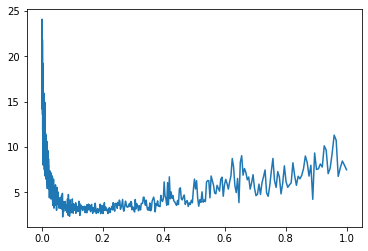

In [276]:

plt.plot(lri, lossi)

* This shows our learning rate is best around 0.1

* Note that more the loss is close to zero, more it is `overfitting`.
* So in practice, in general, It is required to `split up your dataset` into three splits as we call them, `training split`, `dev split/validation split` and third, `test split`.  

* We can split them for example in `80%, 10%, 10%` respectively.

* `training split`: To train parameters.
* `validation split`: To train hyperparameters.
* `test split`: To evaluate performance of our model at the end.

* we can do `other things to improve our model`:
  * we can increase `embedding neurons from 2 to any other number`
  * we can increase `neurons` in the hidden layers.
  * Determine the `learning rate`.
  * `Optimize the size of mini-batch`, so our loss decreases smoothly with every step `(epoch)`.

## Our Fully Fledged MLP model to learn approx. 32,000 names to predict names.

In [303]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # training dataset
Xdev, Ydev = build_dataset(words[n1:n2]) # validation dataset
Xte, Yte = build_dataset(words[n2:]) # test dataset

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [304]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g) # each character splitting into 10 different features (embedding)
W1 = torch.randn((30, 200), generator=g) # weights for first hidden layer, 200 neurons in the first layer.
b1 = torch.randn(200, generator=g) # Bias for these 200 neurons
W2 = torch.randn((200, 27), generator=g) # last layer (output)
b2 = torch.randn(27, generator=g) # bias for 27 neurons (outputs)
parameters = [C, W1, b1, W2, b2] # all the parameters used in our MLP model

In [305]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [306]:
for p in parameters:
  p.requires_grad = True # telling pytorch that we will use gradients in our model.

In [307]:
# making different types of learning rates so to get best learning rate for our model. (use only when optimizing the learning rate)
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [308]:
lri = [] # track of learning rate of each epoch (use only when optimizing the learning rate).
lossi = [] # track of loss after each epoch
stepi = [] # index of each epoch

In [309]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,)) # creating mini batch of size 32.
  
  # forward pass
  emb = C[Xtr[ix]] # (50, 3, 10) # embedding each 3 charactes into 10 different features for each 32 examples.
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200) # first hidden layer has 200 neurons
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix]) # loss is total cross-entropy for 32 total examples.
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None # initializing gradient with NONE.
  loss.backward() # Doing back propagation.
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01 # setting our learning rate. 
  for p in parameters:
    p.data += -lr * p.grad # changing values of each parameters after each epoch using gradient descent.

  # track stats
  #lri.append(lre[i]) # (use only when optimizing the learning rate)
  stepi.append(i) # appending index of each epoch
  lossi.append(loss.log10().item()) # storing loss after taking log.

#print(loss.item())

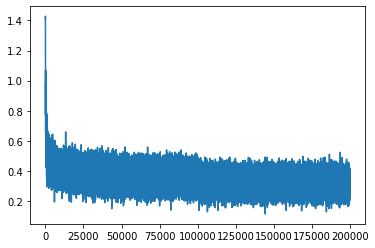

In [310]:
plt.plot(stepi, lossi)

In [311]:
# training loss doing all Xtr together 
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1417, grad_fn=<NllLossBackward0>)

In [312]:
# validation loss doing all Xdev together
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1988, grad_fn=<NllLossBackward0>)

In [313]:
# test loss doing all Xte together
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1941, grad_fn=<NllLossBackward0>)

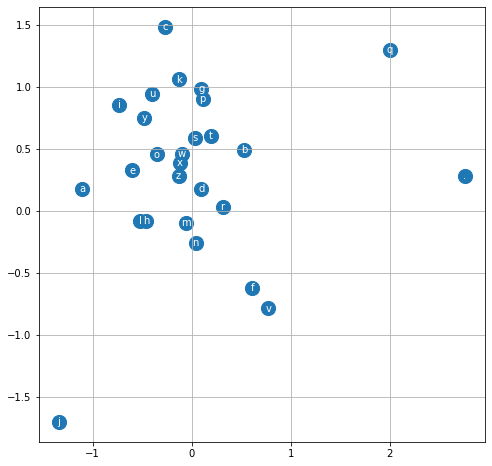

In [314]:
# visualize only dimensions 0 and 1 out of 10 dimensions (10 features of each character) of the embedding matrix C for all characters.
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

#### Sampling from the model (`generating names`)

In [315]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carlah.
aal.
havi.
kemili.
taty.
skansha.
jazon.
nayah.
arciarquia.
ellara.
chaiif.
kaleigh.
ham.
joi.
dessan.
sulin.
alianni.
walell.
dearyn.
kal.
